# Transformer Teardown: Llama 3

> Single token prediction: What is capital of Massachusetts? Boston.

# Setup

In [4]:
from functools import partial
import json
import math
import os
from pathlib import Path
import warnings

from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from pandas import Series
from pytest import approx

import torch
from torch import nn
from torch.nn.functional import relu, silu, softmax

from llama_models.llama3.api.tokenizer import Tokenizer
from llama_models.llama3.reference_impl.model import RMSNorm

import stickshift as ss
from stickshift.torch import device as torch_device
from stickshift import default_arg, take
from stickshift.models import llama

In [5]:
# Ignore all warnings
warnings.filterwarnings("ignore")

# Configure gpu
device = torch_device()

In [6]:
%%html
<style>
.stickshift-figure {
    display: block;
    margin-left: auto !important;
    margin-right: auto !important;
}
</style>

# Text Generation with Llama 3

Our goal is to build a Llama 3 text generation pipeline using the pre-trained weights and Meta's reference implementation as a guide. By the time we're done, our model should be able to correctly answer the question "What is the capital of Massachusetts?"

In [ ]:
question = "What is the capital of Massachusetts?"

# Load Checkpoint

We'll start by loading the hyperparameters and pre-trained weights published by Meta.

In [ ]:
# Load model config
config = llama.config("Meta-Llama3.1-8B-Instruct")

# Load model parameters
checkpoint = torch.load(config.checkpoint_path / "consolidated.00.pth", weights_only=True, map_location=device)

In [ ]:
config.model_dump()

In [ ]:
def load_pretrained_state(layer):    
    # Load pre-trained state
    llama.load_state(
        normalize_attention, "normalize_attention", 
        normalize_ffn, "normalize_ffn", 
        w_q, "w_q", 
        w_k, "w_k", 
        w_v, "w_v", 
        attention_outputs, "attention_outputs",
        ffn_gates, "ffn_gates",
        ffn_inputs, "ffn_inputs",
        ffn_outputs, "ffn_outputs",
        checkpoint=checkpoint,
        layer=layer,
    ) 

In [ ]:
# [k for k in checkpoint]

# Transformer Pipeline

<img src="transformer-pipeline.svg" class="stickshift-figure" width="800">

# Tokenize

The Tokenize stage transforms raw data into a sequence of "tokens".

In [ ]:
tokenizer = Tokenizer(str(config.checkpoint_path / "tokenizer.model"))

In [ ]:
token_ids = tokenizer.encode(question, bos=True, eos=False)
token_ids

In [ ]:
tokenizer.decode(token_ids)

# Embeddings

The Embeddings stage converts tokens into "embeddings".

In [ ]:
# Initialize embeddings lookup table
embeddings = nn.Embedding(
    num_embeddings=config.vocab_size, 
    embedding_dim=config.d_model,
    device=device,
)

# Load pre-trained weights
llama.load_state(embeddings, "embeddings", checkpoint=checkpoint)

In [ ]:
# Load token_ids into a tensor
token_values = torch.tensor(token_ids, device=device)

token_values.shape

In [ ]:
# Record sequence length
n = len(token_values)

n

In [ ]:
# Map token values to embeddings
x = embeddings(token_values)

x.shape

In [ ]:
# Show sample
x

# Context Layers

The Context Layers in a Transformer are responsible for infusing each token embedding with contextual signals drawn from the rest of the sequence. The mechanism works by passing the token embeddings through multiple layers of attention and feedforward blocks. The attention blocks focus on relationships between tokens, augmenting each embedding with contextual information drawn from the surrounding embeddings. The feedforward blocks capitalize on the extra context, transforming each augmented embedding using a fully connected neural network. This pattern of attention and transformation is repeated over and over again, gradually converting representations of individual words into representations of abstract semantic concepts over a series of small increments.

<img src="transformer-layers.svg" class="stickshift-figure" width="800">

## Attention

The attention block augments each token representation with additional context drawn from the surrounding tokens.

<img src="attention.svg" class="stickshift-figure" width="500">

Attention starts with the token embeddings stacked in an $n \times d_{model}$ matrix $\mathbf{X}$. For each embedding $\Set{\mathbf{x}_i | \mathbf{x}_i \in \mathbf{X}}$, we'll generate a new attention embedding $\mathbf{a}_i$ using a weighted combination of all embeddings in $\mathbf{X}$. The equation below emphasizes the fact that the weight for each embedding $\mathbf{x}_j$ is a calculated as a function $f_{w}$ of the embedding values $\mathbf{x}_i$, $\mathbf{x}_j$ and their positions $i$, $j$.

$$
\mathbf{A} = \Set{\mathbf{a}_i | \mathbf{a}_i = \sum_{\mathbf{x}_j \in \mathbf{X}} f_{w}(\mathbf{x}_i, \mathbf{x}_j, i, j) \mathbf{x}_j}
$$

The attention function used by LLama 3 can be rewritten as

$$
\begin{align}
\mathbf{A} &= softmax\left(\frac{\mathbf{Q}\mathbf{K}^T}{\sqrt{d}} + \mathbf{M}\right)\mathbf{V} \\
\end{align}
$$

which expands to

$$
\begin{align}
\mathbf{A} &= softmax\left(\frac{(\mathbf{R}_{\Theta}^d\mathbf{W}_Q\mathbf{X})(\mathbf{R}_{\Theta}^d\mathbf{W}_K\mathbf{X})^T}{\sqrt{d}} + \mathbf{M}\right)\mathbf{W}_V\mathbf{X} \\
\end{align}
$$


### Normalize Inputs

In [ ]:
# Configure attention normalization
normalize_attention = RMSNorm(config.d_model, config.rms_norm_eps).to(device)

# Load pre-trained weights
llama.load_state(normalize_attention, "normalize_attention", checkpoint=checkpoint)

In [ ]:
# Normalize attention inputs
residual = x
x = normalize_attention(x)

x.shape

### Project Queries, Keys, Values

In [ ]:
# Configure query, key, value projections
w_q = nn.Linear(
    in_features=config.d_model,
    out_features=config.n_heads * config.d_head,
    bias=False,
    device=device,
)
w_k = nn.Linear(
    in_features=config.d_model,
    out_features=config.n_kv_heads * config.d_head,
    bias=False,
    device=device,
)
w_v = nn.Linear(
    in_features=config.d_model,
    out_features=config.n_kv_heads * config.d_head,
    bias=False,
    device=device,
)

# Load pre-trained weights
llama.load_state(w_q, "w_q", w_k, "w_k", w_v, "w_v", checkpoint=checkpoint)

In [ ]:
# Project embeddings to query, key, value spaces
q = w_q(x)
k = w_k(x)
v = w_v(x)

q.shape, k.shape, v.shape

### Split Attention Heads

In [ ]:
def split_heads(x, n_heads):
    return x.view(-1, n_heads, config.d_head).transpose(-3, -2)

In [ ]:
# Split attention heads
q = split_heads(q, config.n_heads)
k = split_heads(k, config.n_kv_heads)
v = split_heads(v, config.n_kv_heads)

q.shape, k.shape, v.shape

### Encode Positions (RoPE)

Given $\Theta = \text{base}$, $m = \text{position}$ and $d = d_{head},$ the RoPE rotation matrix $R_{\Theta,m}^d$ can be calculated as:

$$
\mathbf{R}_{\Theta,m}^d \mathbf{x} = 
\begin{bmatrix}
x_0 \\
x_1 \\
x_2 \\
x_3 \\
\vdots \\
x_{d/2-2} \\
x_{d/2-1} \\
\end{bmatrix}
\begin{bmatrix}
cos(m \theta_0) \\
cos(m \theta_0) \\
cos(m \theta_1) \\
cos(m \theta_1) \\
\vdots \\
cos(m \theta_{d/2-1}) \\
cos(m \theta_{d/2-1}) \\
\end{bmatrix}
+
\begin{bmatrix}
-x_1 \\
x_0 \\
-x_3 \\
x_2 \\
\vdots \\
-x_{d/2-1} \\
x_{d/2-2} \\
\end{bmatrix}
\begin{bmatrix}
sin(m \theta_0) \\
sin(m \theta_0) \\
sin(m \theta_1) \\
sin(m \theta_1) \\
\vdots \\
sin(m \theta_{d/2-1}) \\
sin(m \theta_{d/2-1}) \\
\end{bmatrix}             
$$

where

$$
\theta_i = \frac{1}{\Theta^{2i/d}}
$$

In [ ]:
# Compute rope_cos and rope_sin
base = config.rope_theta
d = config.d_head

# Compute theta_i = 1 / base^(2i/d) from i = 0 to d/2-1
thetas = 1.0 / base**(2 * torch.arange(d // 2, device=device) / d)

# Compute m * theta_i for position m in 0 to n
frequencies = torch.stack([m*thetas for m in range(n)])

# Duplicate each row
frequencies = torch.cat((frequencies, frequencies), dim=-1)

# Apply cos, sin
rope_cos = torch.cos(frequencies)
rope_sin = torch.sin(frequencies)

rope_cos.shape, rope_sin.shape

In [ ]:
# Sanity check
assert rope_cos.shape[0] == n and rope_cos.shape[1] == config.d_head
assert rope_sin.shape[0] == n and rope_sin.shape[1] == config.d_head

In [ ]:
# Encode positions by rotating queries and keys
q = (q * rope_cos) + (llama.rotate_half(q) * rope_sin)
k = (k * rope_cos) + (llama.rotate_half(k) * rope_sin)

q.shape, k.shape, v.shape

### Expand Key / Value Groups (GQA)

In [ ]:
# Expand key/value groups
k = k.repeat_interleave(config.n_kv_groups, dim=0)
v = v.repeat_interleave(config.n_kv_groups, dim=0)

q.shape, k.shape, v.shape

In [ ]:
# Sanity check
assert q.shape == k.shape == v.shape

### Calculate Attention

$$
\begin{align}
\mathbf{A} &= softmax\left(\frac{\mathbf{Q}\mathbf{K}^T}{\sqrt{d}} + \mathbf{M}\right)\mathbf{V} \\
\end{align}
$$

In [ ]:
# Compute masked attention bias M
mask = torch.ones(n, n, dtype=torch.bool, device=device).tril(diagonal=0)
m = torch.zeros(n, n, device=device).masked_fill_(mask.logical_not(), float("-inf"))

m

In [ ]:
# Compute attention for all heads in parallel
a = softmax(q @ k.transpose(-2, -1) / np.sqrt(config.d_head) + m, dim=-1) @ v

a.shape

### Recombine Attention Heads

In [ ]:
def combine_heads(x):
    return x.transpose(-3, -2).contiguous().view(-1, int(config.n_heads * config.d_head))

In [ ]:
# Combine attention heads
a = combine_heads(a)

a.shape

### Project Outputs

In [ ]:
# Configure attention output projection
attention_outputs = nn.Linear(
    in_features=config.d_model, 
    out_features=config.d_model,
    bias=False,
    device=device,
)

# Load pre-trained weights
llama.load_state(attention_outputs, "attention_outputs", checkpoint=checkpoint)

In [ ]:
# Project attention embeddings back to model space
a = attention_outputs(a)

a.shape

### Combine w/ Residuals

In [ ]:
# Combine attention embeddings with residuals
x = residual + a

x.shape

## FFN

### Normalize Inputs

In [ ]:
# Configure FFN normalization
normalize_ffn = RMSNorm(config.d_model, config.rms_norm_eps).to(device)

# Load pre-trained state
llama.load_state(normalize_ffn, "normalize_ffn", checkpoint=checkpoint)

In [ ]:
# Normalize FFN inputs
residual = x
x = normalize_ffn(x)

x.shape

### Transform

In [ ]:
# Configure SwiGLU FFN
ffn_gates = nn.Linear(
    in_features=config.d_model,
    out_features=config.d_ffn,
    bias=False,
    device=device,
)
ffn_inputs = nn.Linear(
    in_features=config.d_model,
    out_features=config.d_ffn,
    bias=False,
    device=device,
)

# Load pre-trained weights
llama.load_state(ffn_gates, "ffn_gates", ffn_inputs, "ffn_inputs", checkpoint=checkpoint)

In [ ]:
# Apply FFN
f = silu(ffn_gates(x)) * ffn_inputs(x)

f.shape

### Project Outputs

In [ ]:
# Configure FFN output projection
ffn_outputs = nn.Linear(
    in_features=config.d_ffn,
    out_features=config.d_model,
    bias=False,
    device=device,
)

# Load pre-trained weights
llama.load_state(ffn_outputs, "ffn_outputs", checkpoint=checkpoint)

In [ ]:
# Project FFN embeddings back to model space
f = ffn_outputs(f)

f.shape

### Combine w/ Residuals

In [ ]:
# Combine FFN embeddings with residuals
x = residual + f

x.shape

## Stacking the Layers

In [ ]:
# Start over from initial token embeddings
x = embeddings(token_values)

x.shape

In [ ]:
# Apply layer logic in a loop
for layer in range(config.n_layers):

    # Load pre-trained state for layer
    load_pretrained_state(layer)

    #
    # Attention
    #

    # Normalize attention inputs
    residual = x
    x = normalize_attention(x)
    
    # Project embeddings to query, key, value spaces
    q = w_q(x)
    k = w_k(x)
    v = w_v(x)
    
    # Split attention heads
    q = split_heads(q, config.n_heads)
    k = split_heads(k, config.n_kv_heads)
    v = split_heads(v, config.n_kv_heads)

    # Encode positions by rotating queries and keys
    q = (q * rope_cos) + (llama.rotate_half(q) * rope_sin)
    k = (k * rope_cos) + (llama.rotate_half(k) * rope_sin)
    
    # Expand key/value groups
    k = k.repeat_interleave(config.n_kv_groups, dim=0)
    v = v.repeat_interleave(config.n_kv_groups, dim=0)

    # Compute masked attention bias M
    mask = torch.ones(n, n, dtype=torch.bool, device=device).tril(diagonal=0)
    m = torch.zeros(n, n, device=device).masked_fill_(mask.logical_not(), float("-inf"))
    
    # Compute attention for all heads in parallel
    a = softmax(q @ k.transpose(-2, -1) / np.sqrt(config.d_head) + m, dim=-1) @ v

    # Combine attention heads
    a = combine_heads(a)
    
    # Project attention embeddings back to model space
    a = attention_outputs(a)
    
    # Combine attention embeddings with residuals
    x = residual + a
    
    #
    # FFN
    #

    # Normalize FFN inputs
    residual = x
    x = normalize_ffn(x)

    # Apply FFN
    f = silu(ffn_gates(x)) * ffn_inputs(x)

    # Project FFN embeddings back to model space
    f = ffn_outputs(f)
    
    # Combine FFN embeddings with residuals
    x = residual + f

# Head

## Normalize Inputs

In [ ]:
# Configure head normalization
normalize_head = RMSNorm(config.d_model, config.rms_norm_eps).to(device)

# Load pre-trained weights
llama.load_state(normalize_head, "normalize_head", checkpoint=checkpoint)

In [ ]:
# Normalize head inputs
x = normalize_head(x)

x.shape

## Predict Next Token

In [ ]:
# Configure output projection
head_outputs = nn.Linear(
    in_features=config.d_model,
    out_features=config.vocab_size,
    bias=False,
    device=device,
)

# Load pre-trained weights
llama.load_state(head_outputs, "head_outputs", checkpoint=checkpoint)

In [ ]:
# Use last embedding to represent the entire sequence
features = x[-1]

features.shape

In [ ]:
# Predict next token
logits = head_outputs(features)
token_id = logits.argmax()

tokenizer.decode([token_id])

In [ ]:
# Verify the answer is Boston
assert token_id == 10406

# RoPE


$$
\mathbf{R}_{\Theta,m}^d \mathbf{x} = 
\begin{bmatrix}
x_0 \\
x_1 \\
x_2 \\
x_3 \\
\vdots \\
x_{d/2-2} \\
x_{d/2-1} \\
\end{bmatrix}
\begin{bmatrix}
cos(m \theta_0) \\
cos(m \theta_0) \\
cos(m \theta_1) \\
cos(m \theta_1) \\
\vdots \\
cos(m \theta_{d/2-1}) \\
cos(m \theta_{d/2-1}) \\
\end{bmatrix}
+
\begin{bmatrix}
-x_1 \\
x_0 \\
-x_3 \\
x_2 \\
\vdots \\
-x_{d/2-1} \\
x_{d/2-2} \\
\end{bmatrix}
\begin{bmatrix}
sin(m \theta_0) \\
sin(m \theta_0) \\
sin(m \theta_1) \\
sin(m \theta_1) \\
\vdots \\
sin(m \theta_{d/2-1}) \\
sin(m \theta_{d/2-1}) \\
\end{bmatrix}
$$

Rotation

$$
\begin{bmatrix}
cos(\theta) & -sin(\theta) \\
sin(\theta) & cos(\theta) \\
\end{bmatrix}
$$

Given a 2D vector

$$
x = 
\begin{bmatrix}
4.9 \\
0.9
\end{bmatrix}
$$

and rotation

$$
R = 
\begin{bmatrix}
cos(\theta) & -sin(\theta) \\
sin(\theta) & cos(\theta) \\
\end{bmatrix}
$$

let's calculate

$$
Rx = 
\begin{bmatrix}
4.9cos(\theta) - 0.9sin(\theta) \\
4.9sin(\theta) + 0.9cos(\theta)
\end{bmatrix}
$$

In [10]:
import math

In [11]:
x = torch.tensor([4.9, 0.9])
x

tensor([4.9000, 0.9000])

In [13]:
theta = math.pi / 4
R = torch.tensor([
    [math.cos(theta), -math.sin(theta)],
    [math.sin(theta), math.cos(theta)],
])
R

tensor([[ 0.7071, -0.7071],
        [ 0.7071,  0.7071]])

In [14]:
R@x

tensor([2.8284, 4.1012])

(-5.0, 5.0)

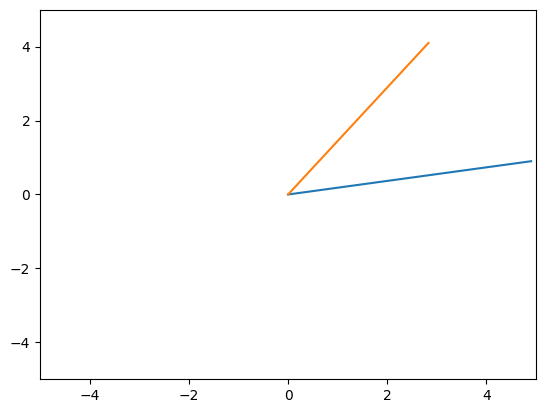

In [18]:
sns.lineplot(x=[0, 4.9], y=[0, 0.9])
sns.lineplot(x=[0, 2.83], y=[0, 4.1])
plt.xlim([-5,5])
plt.ylim([-5,5])

In [8]:
x = torch.tensor([
    [4.9, 0.9],
    [4.7, 1.7],
    [4.3, 2.5],
])
x

tensor([[4.9000, 0.9000],
        [4.7000, 1.7000],
        [4.3000, 2.5000]])

# Scratch

In [ ]:
n = 5

mask = torch.full((n, n), float("-inf"))
mask

In [ ]:
mask.tril(diagonal=1)

In [ ]:
probs = torch.tensor([0.2, 0.1, 0.4, 0.3], device=device)
probs

In [ ]:
probs.sum()

In [ ]:
probs, _ = probs.sort(descending=True)
probs

In [ ]:
cumulative_probs = probs.cumsum(dim=-1)
cumulative_probs

In [ ]:
p = 0.5
mask = cumulative_probs > p
mask

In [ ]:
torch.argmax(mask).item()

In [1]:
from sys import stdout
from textwrap import dedent
import warnings

import torch
import transformers
import stickshift as ss
from stickshift.models import llama

from llama_models.llama3.api.tokenizer import Tokenizer

# Ignore all warnings
warnings.filterwarnings("ignore")

# Configure gpu
device = ss.torch.device()

In [2]:
config = llama.config("Meta-Llama3.1-8B-Instruct")

In [3]:
tokenizer = Tokenizer(str(config.checkpoint_path / "tokenizer.model"))

In [4]:
input_ids = [128000, 128006,   9125, 128007,    271,  38766,   1303,  33025,   2696,
             25,   6790,    220,   2366,     18,    198,  15724,   2696,     25,
            220,   1627,  10263,    220,   2366,     19,    271, 128009, 128006,
            882, 128007,    271,   3923,    374,    279,   6864,    315,  22108,
             30, 128009, 128006,  78191, 128007,    271]

In [5]:
output_ids = [128000, 128006,   9125, 128007,    271,  38766,   1303,  33025,   2696,
             25,   6790,    220,   2366,     18,    198,  15724,   2696,     25,
            220,   1627,  10263,    220,   2366,     19,    271, 128009, 128006,
            882, 128007,    271,   3923,    374,    279,   6864,    315,  22108,
             30, 128009, 128006,  78191, 128007,    271,    791,   6864,    315,
          22108,    374,  10406,     13, 128009]

In [6]:
[tokenizer.decode([input_id]) for input_id in input_ids]

['<|begin_of_text|>',
 '<|start_header_id|>',
 'system',
 '<|end_header_id|>',
 '\n\n',
 'Cut',
 'ting',
 ' Knowledge',
 ' Date',
 ':',
 ' December',
 ' ',
 '202',
 '3',
 '\n',
 'Today',
 ' Date',
 ':',
 ' ',
 '26',
 ' Jul',
 ' ',
 '202',
 '4',
 '\n\n',
 '<|eot_id|>',
 '<|start_header_id|>',
 'user',
 '<|end_header_id|>',
 '\n\n',
 'What',
 ' is',
 ' the',
 ' capital',
 ' of',
 ' Massachusetts',
 '?',
 '<|eot_id|>',
 '<|start_header_id|>',
 'assistant',
 '<|end_header_id|>',
 '\n\n']

In [7]:
[tokenizer.decode([tid]) for tid in output_ids]

['<|begin_of_text|>',
 '<|start_header_id|>',
 'system',
 '<|end_header_id|>',
 '\n\n',
 'Cut',
 'ting',
 ' Knowledge',
 ' Date',
 ':',
 ' December',
 ' ',
 '202',
 '3',
 '\n',
 'Today',
 ' Date',
 ':',
 ' ',
 '26',
 ' Jul',
 ' ',
 '202',
 '4',
 '\n\n',
 '<|eot_id|>',
 '<|start_header_id|>',
 'user',
 '<|end_header_id|>',
 '\n\n',
 'What',
 ' is',
 ' the',
 ' capital',
 ' of',
 ' Massachusetts',
 '?',
 '<|eot_id|>',
 '<|start_header_id|>',
 'assistant',
 '<|end_header_id|>',
 '\n\n',
 'The',
 ' capital',
 ' of',
 ' Massachusetts',
 ' is',
 ' Boston',
 '.',
 '<|eot_id|>']

In [ ]:
transformer = transformers.pipeline(
    "text-generation",
    model="meta-llama/Meta-Llama-3.1-8B-Instruct",
    device=device,
)

In [ ]:
tokenizer = transformer.tokenizer
model = transformer.model

In [ ]:
prompt = dedent(
    """
    <|start_header_id|>user<|end_header_id|>
    What is the capital of Massachusetts?
    <|eot_id|>
    <|start_header_id|>assistant<|end_header_id|>
    """
)

In [ ]:
input_ids = tokenizer.encode(prompt)
input_ids = torch.tensor(input_ids, device=device)
input_ids = input_ids.unsqueeze(0)

input_ids

In [ ]:
attention_mask = torch.ones_like(input_ids)

attention_mask

In [ ]:
output_ids = model.generate(input_ids=input_ids, attention_mask=attention_mask, max_new_tokens=50)

output_ids

In [ ]:
output_ids = [output_id.item() for output_id in output_ids[0]]

In [ ]:
for tid in output_ids:
    stdout.write(f"{tid} ")

128000 198 27 91 2527 8932 851 91 29 882 27 91 408 8932 851 91 397 3923 374 279 6864 315 22108 5380 27 91 68 354 851 91 397 27 91 2527 8932 851 91 29 78191 27 91 408 8932 851 91 397 
Selection deleted


In [ ]:
[tokenizer.decode([output_id]) for output_id in output_ids]

In [ ]:
len(output_ids[0])

In [ ]:
tokenizer